https://www.kaggle.com/competitions/stock-investment-prediction/leaderboard

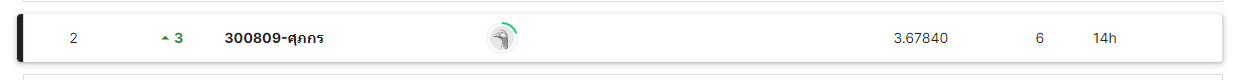

Author: supakorn.fronk@gmail.com

In [ ]:
import os
import random
import numpy as np
import torch

def set_all_seeds(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

set_all_seeds(42)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 28.4 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c stock-investment-prediction

  0% 0.00/12.5k [00:00<?, ?B/s]
100% 12.5k/12.5k [00:00<00:00, 29.2MB/s]


In [ ]:
!unzip /content/stock-investment-prediction.zip

Archive:  /content/stock-investment-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


<Axes: title={'center': 'Closing Price of Asset'}>

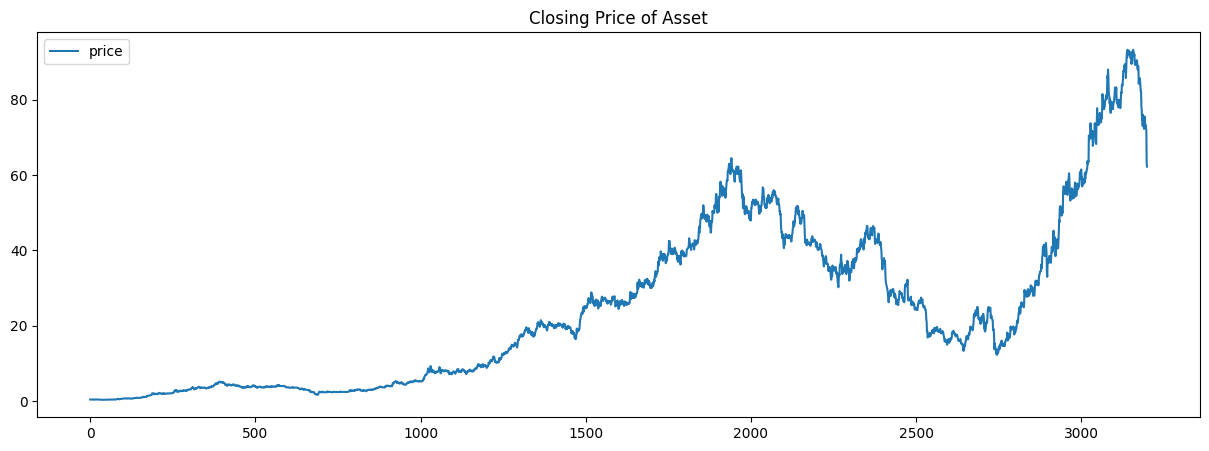

In [ ]:
import pandas as pd
data = pd.read_csv("/content/train.csv")
df = data[["price"]]
df.plot(figsize=(15,5), title="Closing Price of Asset")

In [ ]:
ss = pd.read_csv("/content/sample_submission.csv")
df = pd.concat([df, ss.dropna()[["price"]]], axis=0)
df = df.pct_change()[1:]
df = df.reset_index(drop=True)

<Axes: title={'center': 'Daily percentage change (Daily Return)'}>

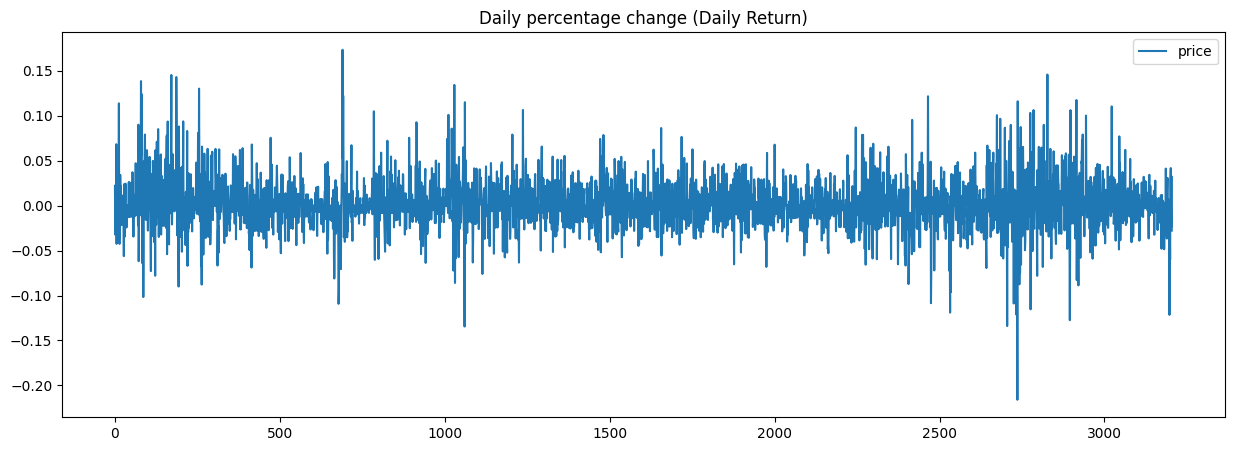

In [ ]:
df.plot(figsize=(15,5), title = 'Daily percentage change (Daily Return)')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
df_norm = scaler.transform(df)

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class Dataset_Custom(Dataset):
    def __init__(self, df, seq_len, pred_len):
        self.df = df
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __getitem__(self, index):
        # input
        input_begin = index
        input_end = input_begin + self.seq_len

        # label
        label_begin = input_end
        label_end = label_begin + self.pred_len

        seq_x = self.df[input_begin:input_end]
        seq_y = self.df[label_begin:label_end]

        return seq_x, seq_y

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len + 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, seq_len, pred_len, kernel_size):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        # Decompsition Kernel Size
        self.decompsition = series_decomp(kernel_size)

        self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        
        # Use this two lines if you want to visualize the weights
        # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
 
        seasonal_output = self.Linear_Seasonal(seasonal_init)

        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

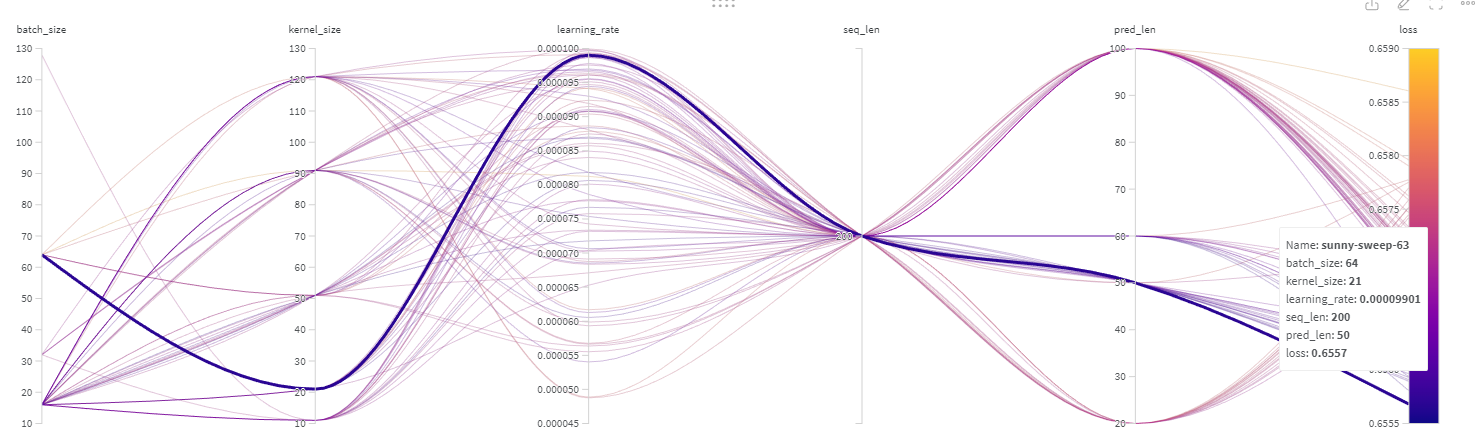

In [ ]:
num_epoch = 100
config = dict(
    batch_size= 64,
    kernel_size= 21,
    learning_rate= 0.00009901,
    seq_len= 200,
    pred_len= 50,
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_set = Dataset_Custom(
        df=df_norm,
        seq_len=config['seq_len'],
        pred_len=config['pred_len']
        )

data_loader = DataLoader(
        data_set,
        batch_size=config['batch_size'],
        shuffle=True,
        drop_last=False)

model = DLinear(seq_len=config['seq_len'],
                pred_len=config['pred_len'],
                kernel_size=config['kernel_size']
                ).to(device)

from tqdm.notebook import tqdm
from torchmetrics import MeanAbsolutePercentageError

optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.L1Loss().to(device)

train_loss_ep = []
for epoch in tqdm(range(num_epoch)):
    train_loss = []

    model.train()
    for i, (batch_x, batch_y) in enumerate(data_loader):
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        outputs = model(batch_x)


        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #log
        train_loss.append(loss.item())

    train_loss_ep.append(np.average(train_loss))

    print(f"Epoch: {epoch+1}/{num_epoch}, Training Loss: {np.average(train_loss)}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Training Loss: 0.833825557789904
Epoch: 2/100, Training Loss: 0.8220166348396464
Epoch: 3/100, Training Loss: 0.8115252307120789
Epoch: 4/100, Training Loss: 0.8022323479043677
Epoch: 5/100, Training Loss: 0.7935585290827649
Epoch: 6/100, Training Loss: 0.7847427966746878
Epoch: 7/100, Training Loss: 0.7769795554749509
Epoch: 8/100, Training Loss: 0.7710206876409814
Epoch: 9/100, Training Loss: 0.7633460760116577
Epoch: 10/100, Training Loss: 0.7564343416944463
Epoch: 11/100, Training Loss: 0.7503158678399756
Epoch: 12/100, Training Loss: 0.7466308816950372
Epoch: 13/100, Training Loss: 0.7399382553202041
Epoch: 14/100, Training Loss: 0.7358290794047904
Epoch: 15/100, Training Loss: 0.731230969124652
Epoch: 16/100, Training Loss: 0.72471425507931
Epoch: 17/100, Training Loss: 0.7208643327368066
Epoch: 18/100, Training Loss: 0.7174929722826532
Epoch: 19/100, Training Loss: 0.7137574984672221
Epoch: 20/100, Training Loss: 0.7116260389064221
Epoch: 21/100, Training Loss: 0.7

<Axes: >

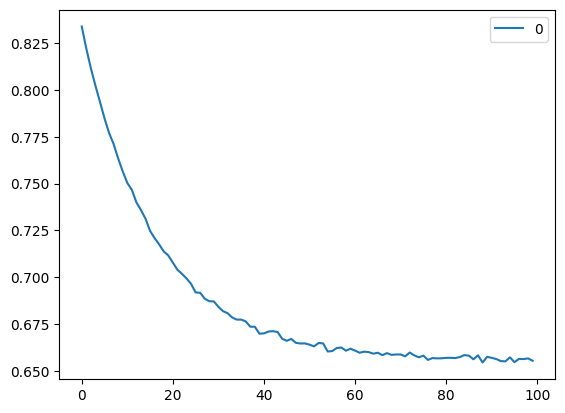

In [ ]:
pd.DataFrame(train_loss_ep).plot()

In [ ]:
df_norm[-config['seq_len']:,:].shape

(200, 1)

In [ ]:
r = df_norm[-config['seq_len']:,:]
for i in range(0,300-6,config['pred_len']):
    x = torch.tensor(r[-config['seq_len']:,:]).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
        output = model(x.float().to(device))
    r = np.append(r, output.squeeze(0).to("cpu").detach().numpy(), axis=0)

<Axes: >

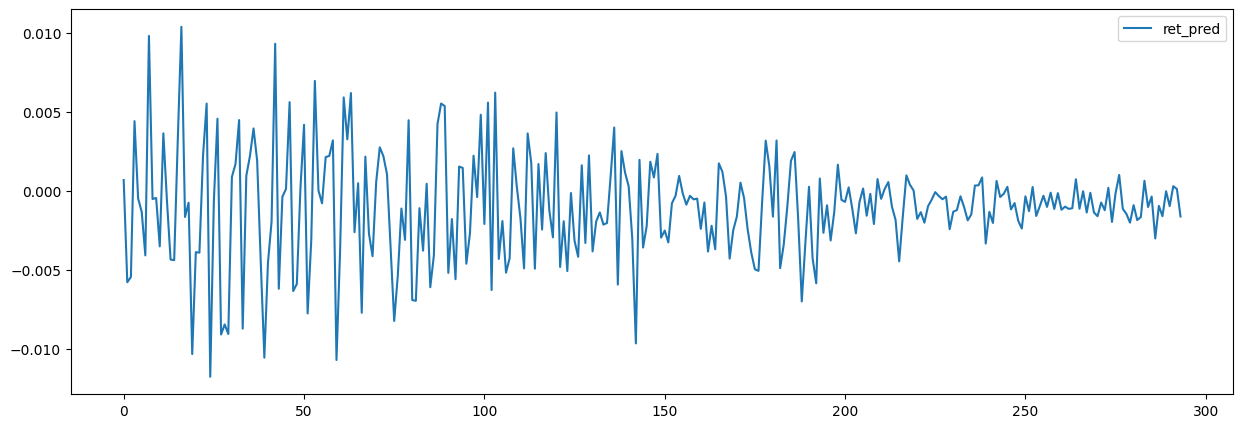

In [ ]:
res_df = pd.DataFrame(scaler.inverse_transform(r[-294:]))
res_df.columns = ["ret_pred"]
res_df.plot(figsize=(15,5))

In [ ]:
ss = pd.read_csv("/content/sample_submission.csv")

<Axes: >

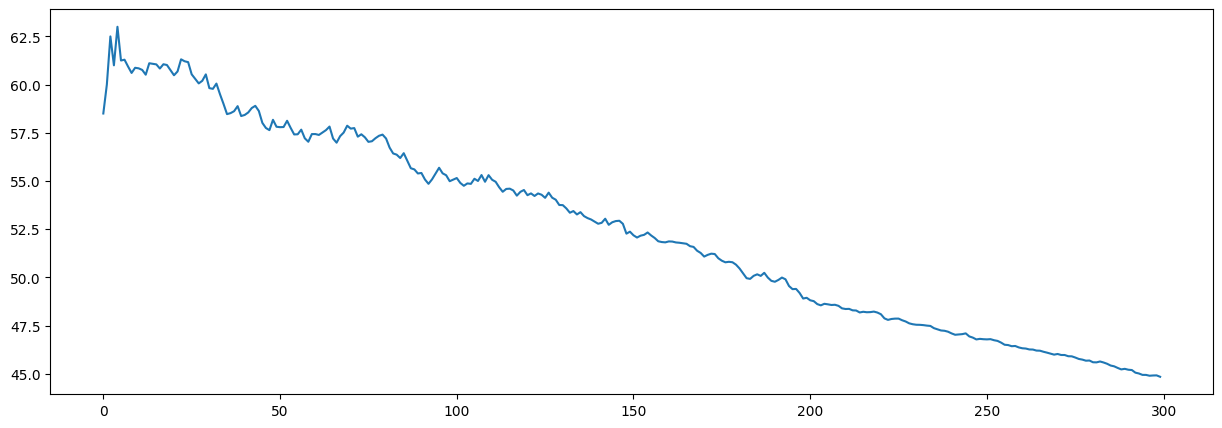

In [ ]:
pred_df = pd.concat([ss.dropna()["price"], (res_df.add(1,fill_value=0).cumprod()*61.25)['ret_pred']], axis=0)
pred_df= pred_df.reset_index(drop=True)
pred_df.plot(figsize=(15,5))

In [ ]:
ss["price"] = pred_df
ss

,id,price
0,3201,58.500000
1,3202,60.000000
2,3203,62.500000
3,3204,61.000000
4,3205,63.000000
...,...,...
295,3496,44.936764
296,3497,44.893518
297,3498,44.906920
298,3499,44.912178


In [ ]:
df = pd.read_csv("/content/train.csv")
df = pd.concat([df, ss]).reset_index(drop=True)
df

,id,price
0,1,0.455000
1,2,0.465000
2,3,0.450000
3,4,0.445000
4,5,0.440000
...,...,...
295,3496,44.936764
296,3497,44.893518
297,3498,44.906920
298,3499,44.912178


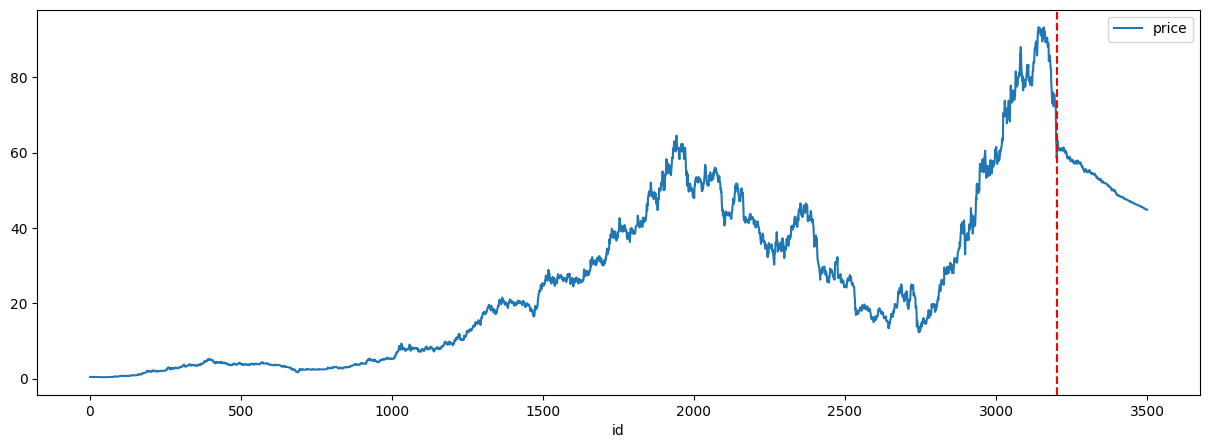

In [ ]:
from matplotlib import pyplot as plt
df.plot(figsize=(15,5),x='id')
plt.axvline(x = 3201, color = 'r', label = 'axvline - full height',linestyle="dashed")

In [ ]:
ss.to_csv("submit.csv", index=False)

In [ ]:
# !kaggle competitions submit -c stock-investment-prediction -f submit.csv -m "150p50-addrelu"

100% 6.74k/6.74k [00:01<00:00, 5.66kB/s]
Successfully submitted to Hackathon Online: Stock Investment Prediction

# wandb hyperparams tuning

In [ ]:
# try:
#     import wandb
# except:
#     !pip install wandb
#     import wandb

# wandb.login()
# # 1: Define objective/training function
# def objective(config):
#     num_epoch = 100
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

#     data_set = Dataset_Custom(
#             df=df_norm,
#             seq_len=config.seq_len,
#             pred_len=config.pred_len
#             )

#     data_loader = DataLoader(
#             data_set,
#             batch_size=config.batch_size,
#             shuffle=True,
#             drop_last=False)

#     model = DLinear(seq_len=config.seq_len,
#                     pred_len=config.pred_len,
#                     kernel_size=config.kernel_size
#                     ).to(device)

#     from tqdm.notebook import tqdm
#     from torchmetrics import MeanAbsolutePercentageError

#     optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
#     criterion = nn.L1Loss().to(device)

#     train_loss_ep = []
#     for epoch in tqdm(range(num_epoch)):
#         train_loss = []

#         model.train()
#         for i, (batch_x, batch_y) in enumerate(data_loader):
            
#             batch_x = batch_x.float().to(device)
#             batch_y = batch_y.float().to(device)

#             outputs = model(batch_x)


#             loss = criterion(outputs, batch_y)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#             #log
#             train_loss.append(loss.item())

#         train_loss_ep.append(np.average(train_loss))

#         # print(f"Epoch: {epoch+1}/{num_epoch}, Training Loss: {np.average(train_loss)}")
#     return np.average(train_loss)

# def main():
#     wandb.init(project='hack-stock-prices-prediction')
#     score = objective(wandb.config)
#     wandb.log({'loss': score})


# # 2: Define the search space


# sweep_configuration = {
#     'method': 'bayes',
#     'metric': 
#     {
#         'goal': 'minimize', 
#         'name': 'loss'
#         },
#     'parameters': 
#     {
#         'seq_len': {'values': [10, 50, 100, 200]},
#         'pred_len': {'values': [20, 50, 60, 100]},
#         'learning_rate':{'max': 0.0001, 'min': 0.00001},
#         'batch_size': {'values': [16, 32, 64, 128]},
#         'kernel_size': {'values': [11, 21, 51, 91, 121]}
#      }
# }


# # 3: Start the sweep
# sweep_id = wandb.sweep(
#     sweep=sweep_configuration, 
#     project='hack-stock-prices-prediction'
#     )

# wandb.agent(sweep_id, function=main, count=100)